# Reading 1D ecRad Output File. Altitude - Temperature Analysis

Version 6: 2023-07-17

This version includes the $q_{i}$ correction and np.gradient for CRH calculation.

Fixed parameters:
1. Radiative Transfer Model: ecRad.
1. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
2. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
3. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
4. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
5. No gases and aerosols.
6. No liquid water.
7. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).

Variable parameters:
1. Macro: Position-Altitude-Temperature from 236 K to 200 K for cloud middle level.
2. Macro: Geometrical Depth $\Delta h = 1.5 km$.
3. Macro: Ice Water Path (IWP) = 30 $g/m^2$ (Around Anvil Cirrus IWP typical value (Sokol & Hartmann 2020)):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz} \;=\; 30\;\frac{g}{m^2}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/kg)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{30\;g/m^2}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
5. Ice Optical Schemes:

    5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
    
    5.2 Yi et al. 2013 (2O).
    
    5.3 Baran et al. 2016 (3O).
    
    5.4 Baran et al. 2014 (4O).
    
    
6. Solvers: Tripleclouds

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu (Fu 1996 / Fu, Yang & Sun 1998)
- 2O: Yi (Yi et al. 2013)
- 3O: Baran2016 (Baran et al. 2016)
- 4O: Baran (Baran et al. 2014)

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for opt in range(1,5):
    file = 'output_1D_matrix_height_'+str(opt)+'O1S_v6.nc'
    globals()['ecrad_out_'+str(opt)+'O1S'] = xr.open_dataset(data_path+file)

### Tropical Profile (to get temperature profile)

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_13558/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_1O1S.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(ecrad_out_1O1S.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Cloud-radiative Heating (CRH) Rate matrix calculation:

Cloud-radiative Heating (CRH) rate in $K\;d^{-1}$ for each spectral component $i$ (SW and LW):

$$CRH_{i} \;=\; - \frac{g_0}{C_P}\frac{\partial }{\partial P}(CRE_{i})\;\;\frac{K}{s}\times\;86400\;\frac{s}{d}$$

where $g_0$ is the standard gravity acceleration ($9.8\;ms^{-2}$), $C_P$ is the specific heat capacity of dry air ($1080\;J kg^{-1} K^{-1}$) and $CRE_{i}$ is the Cloud Radiative Effect for each spectral component $i$ (SW and LW), computed as:

$$CRE_{i} \;=\; F_{All_{i}}^{NET} - F_{Clear_{i}}^{NET}$$

where $F^{NET}$ is the NET irradiance or flux ($Wm^{-2}$), computed as:

$$F_{i}^{NET} \;=\; F_{i}^{Downward} - F_{i}^{Upward}$$

The sign in the CRH equation is because of the definition of the outgoing fluxes as positive ??

In [6]:
tempi = ecrad_out_1O1S.sizes['column']     # Temperature Levels
profi = ecrad_out_1O1S.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

## Heating rates matrices [K day-1]:
H_lw = np.zeros((4, tempi, profi))
H_sw = np.zeros((4, tempi, profi))
H    = np.zeros((4, tempi, profi))

## Matrices for plotting:
H_sw_plot = np.zeros((4, profi, tempi))
H_lw_plot = np.zeros((4, profi, tempi))
H_plot    = np.zeros((4, profi, tempi))

for opt in range(1,5): # per optical scheme
    ecrad_out = eval('ecrad_out_'+str(opt)+'O1S')
    for i in range(tempi):
        pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

        # Net Fluxes [W m-2]
        lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
        lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
        sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
        sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

        # Cloud Radiative Effect [W m-2]
        lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
        sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

        # The sign is because of the definition of Outgoing fluxes as positive:
        # By using the diff function:
        #H_lw[opt-1,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
        #H_sw[opt-1,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)
        # By using the gradient function:
        H_lw[opt-1,i,:] = -(g/cp)*(np.gradient(lw_cre, pres))*86400 # K day^(-1)
        H_sw[opt-1,i,:] = -(g/cp)*(np.gradient(sw_cre, pres))*86400 # K day^(-1)

    H[opt-1,:,:] = H_lw[opt-1,:,:] + H_sw[opt-1,:,:]

    # For plotting:
    H_sw_plot[opt-1,:,:] = np.transpose(H_sw[opt-1,:,:])
    H_lw_plot[opt-1,:,:] = np.transpose(H_lw[opt-1,:,:])
    H_plot[opt-1,:,:]    = np.transpose(H[opt-1,:,:])

#### Plotting 1 single-column CRH (lower height cloud)

<IPython.core.display.Javascript object>


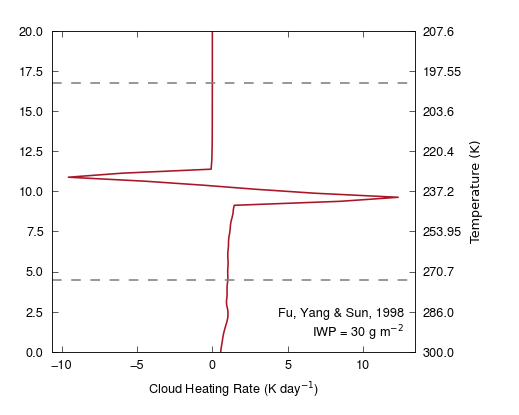

In [7]:
fontname  = 'Nimbus Sans'
fontsize  = 16
my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']
flength    = 9 # inches
fheigth    = flength*.8 # inches
f, ax      = plt.subplots(figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left = 0.1, right = 0.8)

h1 = ax.plot(H_lw_plot[0,:,-1],  height_hl_pd,
             linestyle = 'solid', linewidth = 2,
             color = my_colors[1], alpha = 1)
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# X Axis:
ax.set_xlabel(r'Cloud Heating Rate (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
              color = 'black',labelpad = 10)
#major_ticks_x = np.arange(-60,60,3)
#minor_ticks_x = np.arange(-60,60,1)
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_xlim(-15,15)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
    
# Y Axis:
#ax.set_ylabel('Height (km)', fontname = fontname, fontsize = fontsize,
#              color = 'black', labelpad = 10)
#major_ticks_y = np.arange(-60,60,3)
#minor_ticks_y = np.arange(-60,60,1)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0,20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)', fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.97, 0.03, 'Fu, Yang & Sun, 1998'+
        '\n'+r'IWP = 30 g m$^{-2}$',
        ha = 'right', va = 'bottom', transform = ax.transAxes,
        fontname = fontname, fontsize = fontsize, color = 'black')
        
# Legend:
#handles = h1 + h2 + h3
#labels  = ['SW CRH','LW CRH','CHR']    
#legend  = plt.legend(handles, labels, loc = 'upper right',#bbox_to_anchor=(.675, 1.075),#
#                     ncol = 1, handlelength = 1.5, handletextpad = 1,
#                     labelspacing = .1, columnspacing = 2, numpoints = 1,
#                     frameon = False, prop = {'size':fontsize})

# Additional Texts:
# ax.set_title('BOD Degradation over time',
#              fontsize=fontsize,
#              fontweight='bold',
#              color='black')
#ax.text(0.95, 0.05, r'1O1S 0.2 $g/kg^{-1}$'+'\n'+'10 K depth',
#        ha = 'right', va = 'bottom', transform = ax.transAxes,
#        fontsize = fontsize, color = 'black')

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_1O1S0A_236_v6.png', dpi = 500)

#### Baran and Fu single CRH profile comparison

In [8]:
fu_plot_line    = H_plot[0,:,-5]
baran_plot_line = H_plot[2,:,-5]



# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(T.min(), T.max(), 300)  

power_smooth = spline(T, power, xnew)

NameError: name 'T' is not defined

In [9]:
fontname  = 'Nimbus Sans'
fontsize  = 16
my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']
flength    = 9 # inches
fheigth    = flength*.8 # inches
f, ax      = plt.subplots(figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left = 0.1, right = 0.8)

h1 = ax.plot(H_plot[0,:,-1], height_hl_pd,
             linestyle = 'solid', linewidth = 2,
             color = my_colors[0], alpha = 1)
h2 = ax.plot(H_plot[2,:,-1], height_hl_pd,
             linestyle = 'solid', linewidth = 2,
             color = my_colors[1], alpha = 1)
h3 = ax.axvline(x = 0, linestyle = 'solid', color = 'black', linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

ax.spines[['right', 'top', 'left']].set_visible(False)

# X Axis:
ax.set_xlabel(r'Cloud-radiative heating rate (K day$^{-1}$)', fontname = fontname, 
              fontsize = fontsize, color = 'black', labelpad = 10)
#ax.set_xlim(-15,15)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 3, direction = 'out', top = False,
               labelsize = fontsize, pad=10)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)

    
# Y Axis:
#ax.set_ylabel('Height (km)', fontname = fontname, fontsize = fontsize,
#              color = 'black', labelpad = 10)

ax.set_ylim(0,20)
ax.tick_params(axis = 'y', color = 'black',
               right = False, left = False, labelleft = False)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', left = False,
               labelsize = fontsize, pad = 10)
#plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
      
# Legend:
handles = h1 + h2
labels  = ['Columns', 'Aggregates']    
legend  = plt.legend(handles, labels, loc = 'upper right',#bbox_to_anchor=(.675, 1.075),#
                    ncol = 1, handlelength = 1.5, handletextpad = 1,
                    labelspacing = .3, columnspacing = 2, numpoints = 1,
                    frameon = False, prop = {'size':fontsize})

# Additional Texts:
# ax.set_title('BOD Degradation over time',
#              fontsize=fontsize,
#              fontweight='bold',
#              color='black')
#ax.text(0.95, 0.05, r'1O1S 0.2 $g/kg^{-1}$'+'\n'+'10 K depth',
#        ha = 'right', va = 'bottom', transform = ax.transAxes,
#        fontsize = fontsize, color = 'black')

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_1O1S0A_236_v6.png', dpi = 500)

IndentationError: unexpected indent (4118959537.py, line 47)

#### Checking middle cloud

In [ ]:
temp_range

In [ ]:
fontname  = 'Nimbus Sans'
fontsize  = 16
my_colors = [(88/255, 148/255, 197/255), (229/255, 179/255, 69/255),
             (169/255, 23/255, 38/255), (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']
flength    = 9 # inches
fheigth    = flength*.8 # inches
f, ax      = plt.subplots(figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left = 0.1, right = 0.8)

for i in [0, 10, 21]:
    color = my_colors[[0, 10, 21].index(i)]
    h1 = ax.plot(H_sw_plot[0,:,i],  height_hl_pd, '.-', markersize = 12,
                 color = color, alpha = 1)
    melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
    h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                    dashes = (6, 6), linewidth  =2)
    tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
    h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                    dashes = (6, 6), linewidth  =2)
    h4 = ax.axvline(x = 0, linestyle = 'dashed', color = 'grey',
                    dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# X Axis:
ax.set_xlabel(r'Cloud Heating Rate (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
              color = 'black',labelpad = 10)
#major_ticks_x = np.arange(-60,60,3)
#minor_ticks_x = np.arange(-60,60,1)
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_xlim(-15,15)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
    
# Y Axis:
#ax.set_ylabel('Height (km)', fontname = fontname, fontsize = fontsize,
#              color = 'black', labelpad = 10)
#major_ticks_y = np.arange(-60,60,3)
#minor_ticks_y = np.arange(-60,60,1)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0,20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)', fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.97, 0.03, 'Fu, 1996'+
        '\n'+r'IWP = 30 g m$^{-2}$',
        ha = 'right', va = 'bottom', transform = ax.transAxes,
        fontname = fontname, fontsize = fontsize, color = 'black')
        
# Legend:
#handles = h1 + h2 + h3
#labels  = ['SW CRH','LW CRH','CHR']    
#legend  = plt.legend(handles, labels, loc = 'upper right',#bbox_to_anchor=(.675, 1.075),#
#                     ncol = 1, handlelength = 1.5, handletextpad = 1,
#                     labelspacing = .1, columnspacing = 2, numpoints = 1,
#                     frameon = False, prop = {'size':fontsize})

# Additional Texts:
# ax.set_title('BOD Degradation over time',
#              fontsize=fontsize,
#              fontweight='bold',
#              color='black')
#ax.text(0.95, 0.05, r'1O1S 0.2 $g/kg^{-1}$'+'\n'+'10 K depth',
#        ha = 'right', va = 'bottom', transform = ax.transAxes,
#        fontsize = fontsize, color = 'black')

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_1O1S0A_236_v6.png', dpi = 500)

Why am I having a greater CRH? I was expecting lower because of less q_i and np.gradient. 

#### Plotting CRH Matrix

In [10]:
print(H_lw_plot.max())
print(H_sw_plot.max())
print(H_plot.max())
print(H_lw_plot.min())
print(H_sw_plot.min())
print(H_plot.min())

59.23353455921734
13.675190194695409
64.0160049465448
-9.994865460976017
-0.7029270930259816
-4.732501609238186


As we have higher upper limit than the absolute value of the lower limit, we should normalize the range to have a colorbar "white" point centered in 0:

In [11]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


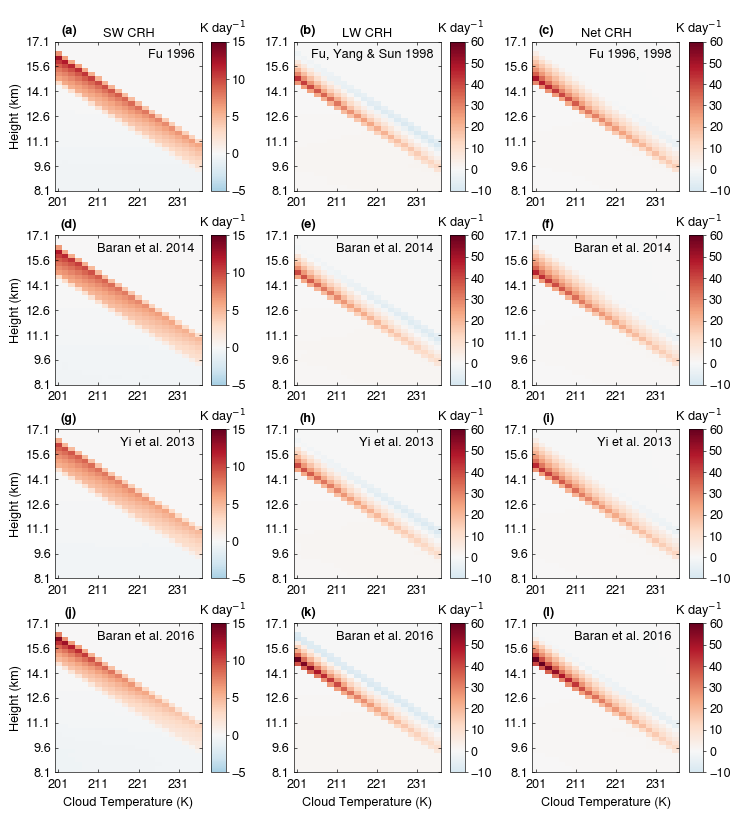

In [12]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 14.5 # inches
flength  = 12.75 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.075, left = 0.075, right = 0.975, 
                    hspace = .3, wspace = .3)

# COLORMAPS
vmini = -10
vmaxi = 60
tickbar = [vmini, 0 ,10, 20, 30, 40, 50, vmaxi]

#For shortwave:
vmini_sw = -5
vmaxi_sw = 15
tickbar_sw = [vmini_sw, 0 , 5, 10, vmaxi_sw]

Sch_order = [0, 3, 1, 2] # Fu, Baran 2014, Yi and Baran2016

for opt in range(rows):
    sch = Sch_order[opt]
    
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = -30, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot[sch], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H.shape[2]+1, 6) # altitude tick labels
yticklabels = height_hl_pd.loc[yticks].round(1).to_list()    
    
# X Axis:
xticks      = np.arange(0, 24, 6)
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
    
OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows):
    sch = Sch_order[opt]
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Cloud Temperature (K)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[opt, j].text(0.95, 0.95, OptSch_sw[sch],
                            ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[opt, j].text(0.95, 0.95, OptSch_lw[sch],
                            ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[opt, j].text(0.95, 0.95, OptSch[sch],
                            ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[opt, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_1S_v6.png', dpi=500)

#### Plotting for paper format

Fu scheme is shown as the example:

In [13]:
print(H_lw_plot[0].max())
print(H_sw_plot[0].max())
print(H_plot[0].max())
print(H_lw_plot[0].min())
print(H_sw_plot[0].min())
print(H_plot[0].min())

43.2017569093656
12.447910444216078
49.12167660020339
-9.659617131257649
-0.5547093910659702
-3.6042830474282166


<IPython.core.display.Javascript object>


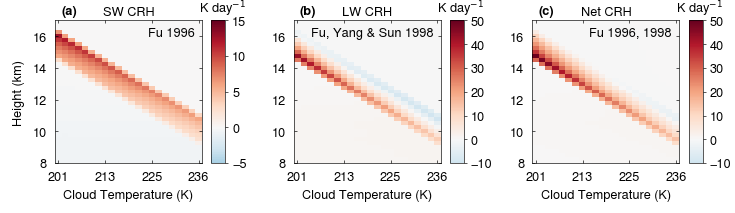

In [14]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
flength  = 12.75 # inches
fheigth  = flength*0.29 # inches

rows    = 1
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.23, left = 0.075, right = 0.975, 
                    hspace = .3, wspace = .3)

# COLORMAPS
vmini = -10
vmaxi = 50
tickbar = [vmini, 0, 10, 20, 30, 40, vmaxi]
#For shortwave:
vmini_sw = -5
vmaxi_sw = 15
tickbar_sw = [vmini_sw, 0 , 5, 10, vmaxi_sw]

# Shortwave Heating Rate
im = ax[0].imshow(H_sw_plot[0], cmap = 'RdBu_r', aspect = 'auto',
                  norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)) 
cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
cbar.set_label(r'K day$^{-1}$', labelpad = -30, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize, pad = 5)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
ax[0].set_title('SW CRH', color = 'black',
                fontsize = fontsize, fontname = fontname)

# Longwave Heating Rate
im = ax[1].imshow(H_lw_plot[0], cmap = 'RdBu_r', aspect = 'auto', 
                  norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize, pad = 5)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
ax[1].set_title('LW CRH', color = 'black',
                fontsize = fontsize, fontname = fontname)

# Heating Rate
im = ax[2].imshow(H_plot[0], cmap = 'RdBu_r', aspect = 'auto',
                  norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize, pad = 5)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
ax[2].set_title('Net CRH', color ='black',
                fontsize = fontsize, fontname = fontname)


# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for j in range(columns):
    # Horizontal Lines:
    #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    ax[j].set_xlabel(r'Cloud Temperature (K)', 
                     fontsize = fontsize, fontname = fontname,
                     color ='black', labelpad = 7.5)
    ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                      size = 4, direction = 'in', top = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_xticklabels():
        tick.set_fontname(fontname)
    ax[j].set_xticks(xticks)
    ax[j].set_xticklabels(xticklabels) #[::-1]
    ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                      size = 4, direction = 'in', right = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_yticklabels():
        tick.set_fontname(fontname)
    ax[j].set_yticks(yticks)
    ax[j].set_yticklabels(yticklabels)
    if j == 0:
        ax[j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                         color ='black', labelpad = 10)
        ax[j].text(0.95, 0.95, OptSch_sw[0],
                   ha = 'right', va = 'top', transform = ax[j].transAxes,
                   fontsize = fontsize, fontname = fontname, color = 'black')
    if j == 1:
        ax[j].text(0.95, 0.95, OptSch_lw[0],
                   ha = 'right', va = 'top', transform = ax[j].transAxes,
                   fontsize = fontsize, fontname = fontname, color = 'black')
    if j == 2:
        ax[j].text(0.95, 0.95, OptSch[0],
                   ha = 'right', va = 'top', transform = ax[j].transAxes,
                   fontsize = fontsize, fontname = fontname, color = 'black')
    ax[j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
    # Panel letters:
    ax[j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
               ha = 'right', va = 'top', transform = ax[j].transAxes,
               fontsize = fontsize, fontname = fontname, color = 'black')
    panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_1S_v6c_paper.png', dpi=500)

#### Plotting Difference between matrices

In [15]:
# Shortwave:
H_sw_diff_plot    = np.zeros((3, profi, tempi))
H_sw_diff_plot[0] = H_sw_plot[1] - H_sw_plot[0] # Yi - Fu
H_sw_diff_plot[1] = H_sw_plot[2] - H_sw_plot[0] # Baran2016 - Fu
H_sw_diff_plot[2] = H_sw_plot[3] - H_sw_plot[0] # Baran2014 - Fu

# Longwave:
H_lw_diff_plot    = np.zeros((3, profi, tempi))
H_lw_diff_plot[0] = H_lw_plot[1] - H_lw_plot[0] # Yi - Fu
H_lw_diff_plot[1] = H_lw_plot[2] - H_lw_plot[0] # Baran2016 - Fu
H_lw_diff_plot[2] = H_lw_plot[3] - H_lw_plot[0] # Baran2014 - Fu

# Net:
H_diff_plot    = np.zeros((3, profi, tempi))
H_diff_plot[0] = H_plot[1] - H_plot[0] # Yi - Fu
H_diff_plot[1] = H_plot[2] - H_plot[0] # Baran - Fu
H_diff_plot[2] = H_plot[3] - H_plot[0] # Baran - Fu

In [16]:
# Shortwave CRH differences:
print('Shortwave CRH Differences:')
print('Yi - Fu max: ',H_sw_diff_plot[0].max())
print('Yi - Fu min: ',H_sw_diff_plot[0].min())
print('Baran2016 - Fu max: ',H_sw_diff_plot[1].max())
print('Baran2016 - Fu min: ',H_sw_diff_plot[1].min())
print('Baran2014 - Fu max: ',H_sw_diff_plot[2].max())
print('Baran2014 - Fu min: ',H_sw_diff_plot[2].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences:')
print('Yi - Fu max: ',H_lw_diff_plot[0].max())
print('Yi - Fu min: ',H_lw_diff_plot[0].min())
print('Baran2016 - Fu max: ',H_lw_diff_plot[1].max())
print('Baran2016 - Fu min: ',H_lw_diff_plot[1].min())
print('Baran2014 - Fu max: ',H_lw_diff_plot[2].max())
print('Baran2014 - Fu min: ',H_lw_diff_plot[2].min())

print('')
# Net CRH differences:
print('Net CRH Differences:')
print('Yi - Fu max: ',H_diff_plot[0].max())
print('Yi - Fu min: ',H_diff_plot[0].min())
print('Baran2016 - Fu max: ',H_diff_plot[1].max())
print('Baran2016 - Fu min: ',H_diff_plot[1].min())
print('Baran2014 - Fu max: ',H_diff_plot[2].max())
print('Baran2014 - Fu min: ',H_diff_plot[2].min())

Shortwave CRH Differences:
Yi - Fu max:  0.0935911711937139
Yi - Fu min:  -2.2909030975768143
Baran2016 - Fu max:  1.2272797504793314
Baran2016 - Fu min:  -2.5182521355888134
Baran2014 - Fu max:  0.35372405159642817
Baran2014 - Fu min:  -1.0835578615863497

Longwave CRH Differences:
Yi - Fu max:  1.4894992746837898
Yi - Fu min:  -3.4925222642901943
Baran2016 - Fu max:  16.03177764985174
Baran2016 - Fu min:  -8.785502996119627
Baran2014 - Fu max:  1.8836622346641647
Baran2014 - Fu min:  -3.6091088881344433

Net CRH Differences:
Yi - Fu max:  0.08126055405244026
Yi - Fu min:  -4.076007015102519
Baran2016 - Fu max:  14.894328346341403
Baran2016 - Fu min:  -7.558223245640296
Baran2014 - Fu max:  1.3728995437601217
Baran2014 - Fu min:  -3.2875242808329332


Last version (2024-02-05) change: For paper format, Baran14-Fu first, Yi-Fu at second row and Baran16-Fu at the end:

<IPython.core.display.Javascript object>


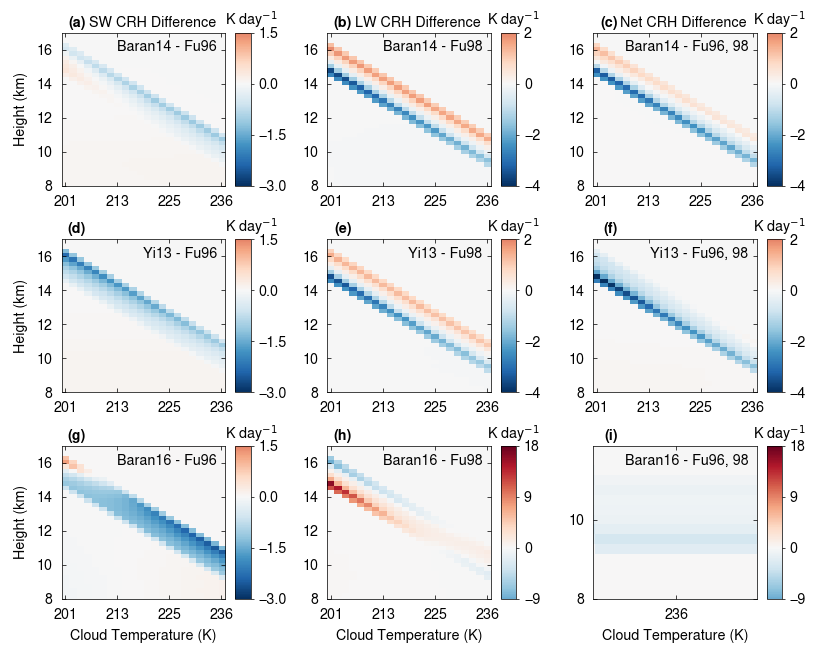

In [17]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.1 # inches
flength  = 12.75 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.97, 
                    hspace = .35, wspace = .3)

# COLORMAPS
#For SW:
vmini_sw   = -3
vmaxi_sw   = 1.5
tickbar_sw = [vmini_sw, -1.5 , 0, vmaxi_sw]

IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu

for diff in range(rows): 
    IntSch = IntSch_order[diff]
    if IntSch == 1:
        vmini    = -9
        vmaxi    = 18
        tickbar  = [vmini, 0 , 9, vmaxi]
        labelpad = -30
    else:
        vmini    = -4
        vmaxi    = 2
        tickbar  = [vmini, -2, 0, vmaxi]
        labelpad = -30
    
    # Shortwave Heating Rate Difference
    im = ax[diff, 0].imshow(H_sw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title('SW CRH Difference', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(H_lw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto', 
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title('LW CRH Difference', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[diff, 2].imshow(H_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 2].set_title('Net CRH Difference', color ='black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Yi13 - Fu96', 'Baran16 - Fu96', 'Baran14 - Fu96']
Diff_lw         = ['Yi13 - Fu98', 'Baran16 - Fu98', 'Baran14 - Fu98']
Diff            = ['Yi13 - Fu96, 98', 'Baran16 - Fu96, 98', 'Baran14 - Fu96, 98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[IntSch],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[IntSch],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[diff, j].text(0.95, 0.95, Diff[IntSch],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c_paper.png', dpi=500)

Inspection of matrix:

Difference:

In [ ]:
f, ax = plt.subplots()
ax.plot(H_sw_diff_plot[0,:,0], height_hl[0,:], '.', color = 'b', markersize = 4, label= 'top - diff')
ax.plot(H_sw_diff_plot[0,:,-1], height_hl[0,:], '.', color = 'r', markersize = 4, label= 'bottom - diff')
ax.plot(H_sw_plot[0,:,0], height_hl[0,:], 's', color = 'b', linestyle = 'dashed', markersize = 4, label= 'top - Fu')
ax.plot(H_sw_plot[0,:,-1], height_hl[0,:], 's', color = 'r', linestyle = 'dashed', markersize = 4, label= 'top - Fu')
ax.legend()

In [ ]:
H_sw_diff_plot[0,:,-1]

Reference (Fu):

In [ ]:
H_sw_plot[0,:,-1]